In [36]:
import sys
sys.path.append('..')

from genetic_algorithm import GeneticAlgorithm
from signals import Signal
import hyperspaces
import pandas as pd
import numpy as np
from tqdm import tqdm
import vectorbt as vbt
import matplotlib.pyplot as plt
import empyrical as ep


##### Define parameters

In [52]:
asset = 'EURUSD'
poplogs_filename = '../results/EURUSD_L_linear_fit_adj_sharpe_100_1d_unlimited.csv'
direction = 'L'
close_data_path = '../data/EURUSD_YFINANCE_1D.csv'
oos_timestamp = '2023-01-01'


##### Load data

In [102]:
# Load OHLCV data
df = pd.read_csv(close_data_path)
df.set_index('time', inplace=True)
df.index = pd.to_datetime(df.index)
df.dropna(inplace=True)
close = df.Close.to_frame(name=asset)
_open = df.Open.to_frame(name=asset)
high = df.High.to_frame(name=asset)
low = df.Low.to_frame(name=asset)
volume = df.Volume.to_frame(name=asset)

##### Initialize Genetic Algorithm


In [56]:
# Initialize GA
ga = GeneticAlgorithm(
        hyperspace=hyperspaces.close_only_hyperspace,
        close=close,
        _open=_open,
        high=high,
        low=low,
        volume=volume,
        direction=direction,
        asset=asset,
        fitness_option='linear_fit_adj_sharpe',
        n_trades_threshold_option='unlimited',
        n_trades_threshold=100
    )

##### Inspect Poplogs


In [57]:
poplogs = pd.read_csv(poplogs_filename)
poplogs.drop_duplicates(subset='individual', inplace=True)
poplogs.sort_values(by='fitness_score', ascending=False, inplace=True)
poplogs


,Unnamed: 0,individual,fitness_score,generation
31475,75,(MACD() > 0) & (WMA(100) < close) $ (RSI(2) > 75),2.610652,314
86650,50,(CONSECUTIVE_HIGHS() < 3) & (DEMA(20) > close)...,1.317859,866
90805,5,(SORTINO(50) > -3) & (DEMA(200) < close) & (HM...,1.314195,908
37389,89,"(DEMA(200) < close) & (BBAND_UPPER(20, 1.0) > ...",0.931400,373
74974,74,(RSI(100) > 50) & (DEMA(20) > close) $ (T3(20)...,0.504094,749
...,...,...,...,...
99995,95,(HMA(400) > close) & (SORTINO(100) > -5) & (CO...,NaN,999
99996,96,(TMA(200) < close) $ (RSI(2) < 30),NaN,999
99997,97,(LINEARREG(100) < close) $ (HMA(400) < close) ...,NaN,999
99998,98,(SORTINO(50) < -4) & (APO() > 0) $ (SHARPE(100...,NaN,999


<Axes: ylabel='Frequency'>

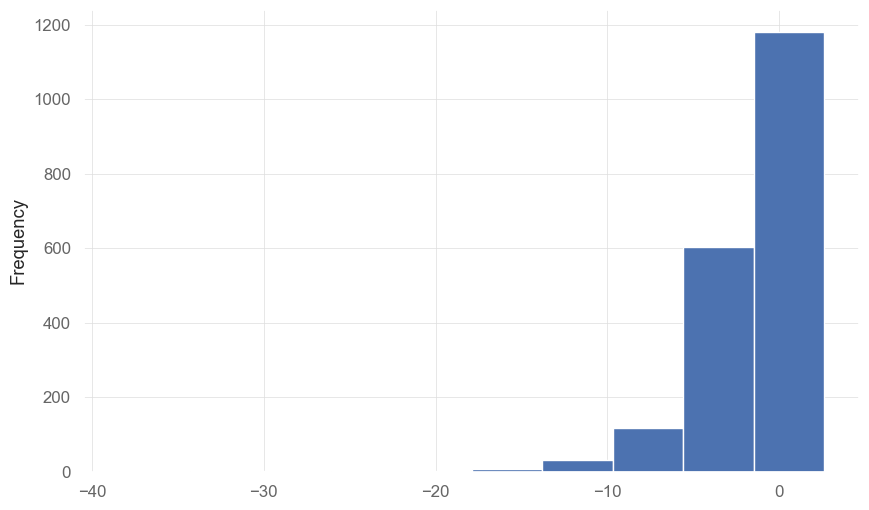

In [58]:
poplogs.fitness_score.plot(kind='hist')


##### Specify individual


In [108]:
individual = poplogs.iloc[2].individual
# individual = '(BARPATH(3) == True) $ (BARPATH(6) == True)'
individual

'(SORTINO(50) > -3) & (DEMA(200) < close) & (HMA(20) > close) $ (SMA(20) < close)'

##### Test on detrended

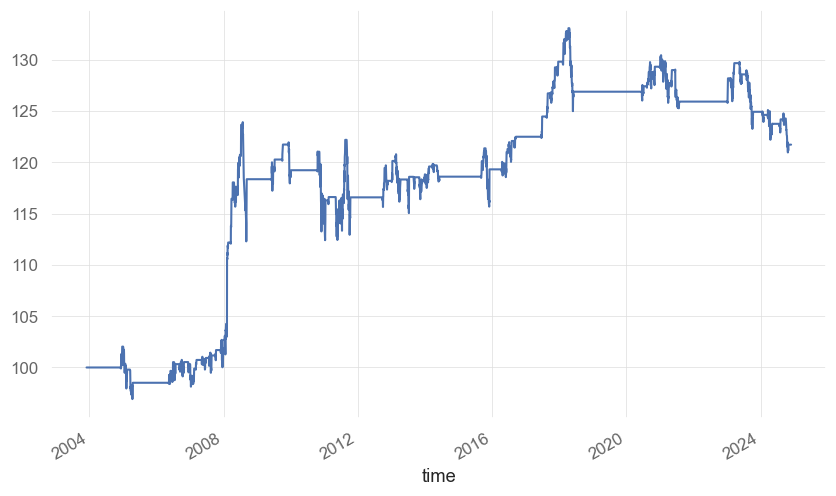

In [106]:
# Detrend the price
_close = close.copy()
ret = close.pct_change().dropna()
close = ret.sub(ret.mean()).add(1).cumprod().mul(_close.iloc[0])

i = ga.explode_individual(individual)
i = i.replace('self.', '')
entry_part, exit_part = i.split('$')

entries = eval(entry_part)
exits = eval(exit_part)

entries.index.name = close.index.name
exits.index.name = close.index.name

if direction == 'L':
    pf = vbt.Portfolio.from_signals(close[asset], entries=entries[asset], exits=exits[asset], fees=0.001)
elif direction == 'S':
    pf = vbt.Portfolio.from_signals(close[asset], short_entries=entries[asset], short_exits=exits[asset], fees=0.001)
elif direction == 'LS':
    pf = vbt.Portfolio.from_signals(close[asset], entries=entries[asset], short_entries=exits[asset], fees=0.001)

pf.value().plot()

close = _close.copy()


##### Simple Backtest

In [109]:
# Run backtest on best individual
i = ga.explode_individual(individual)
i = i.replace('self.', '')
entry_part, exit_part = i.split('$')

entries = eval(entry_part)
exits = eval(exit_part)

entries.index.name = close.index.name
exits.index.name = close.index.name

if direction == 'L':
    pf = vbt.Portfolio.from_signals(close[asset], entries=entries[asset], exits=exits[asset], fees=0.001)
elif direction == 'S':
    pf = vbt.Portfolio.from_signals(close[asset], short_entries=entries[asset], short_exits=exits[asset], fees=0.001)
elif direction == 'LS':
    pf = vbt.Portfolio.from_signals(close[asset], entries=entries[asset], short_entries=exits[asset], fees=0.001)

# # Plot portfolio value
# fig, ax = plt.subplots(figsize=(10, 3))
# close.div(close.iloc[0]).mul(100).plot(ax=ax, label='Buy and Hold')
# pf.value().plot(ax=ax, label='Individual')
# ax.set_title(individual)
# ax.set_xlabel('')
# ax.legend()
# plt.show()

pf.plot()


FigureWidget({
    'data': [{'legendgroup': '0',
              'line': {'color': '#1f77b4'},
              'name': 'Close',
              'showlegend': True,
              'type': 'scatter',
              'uid': '76d18526-9468-4d93-b50a-5cebb960dbd4',
              'x': array([datetime.datetime(2003, 12, 1, 0, 0),
                          datetime.datetime(2003, 12, 2, 0, 0),
                          datetime.datetime(2003, 12, 3, 0, 0), ...,
                          datetime.datetime(2024, 11, 26, 0, 0),
                          datetime.datetime(2024, 11, 27, 0, 0),
                          datetime.datetime(2024, 11, 28, 0, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([1.19650137, 1.20889747, 1.21229756, ..., 1.04443002, 1.04911983,
                          1.05385184]),
              'yaxis': 'y'},
             {'customdata': array([[0.00000000e+00, 8.26033968e+01, 9.99000999e-02],
                                   [2.00000000e+00, 8.32124904e+01,

##### Out of sample backtest


In [115]:
# Load OHLCV data
df = pd.read_csv(close_data_path)
df.set_index('time', inplace=True)
df.index = pd.to_datetime(df.index)
df = df.loc[:oos_timestamp]
df.dropna(inplace=True)
close = df.Close.to_frame(name=asset)
_open = df.Open.to_frame(name=asset)
high = df.High.to_frame(name=asset)
low = df.Low.to_frame(name=asset)
volume = df.Volume.to_frame(name=asset)

# Run backtest on best individual
i = ga.explode_individual(individual)
i = i.replace('self.', '')
entry_part, exit_part = i.split('$')

entries = eval(entry_part)
exits = eval(exit_part)

entries.index.name = close.index.name
exits.index.name = close.index.name

if direction == 'L':
    pf = vbt.Portfolio.from_signals(close[asset], entries=entries[asset], exits=exits[asset], fees=0.001)
elif direction == 'S':
    pf = vbt.Portfolio.from_signals(close[asset], short_entries=entries[asset], short_exits=exits[asset], fees=0.001)
elif direction == 'LS':
    pf = vbt.Portfolio.from_signals(close[asset], entries=entries[asset], short_entries=exits[asset], fees=0.001)


# # Plot portfolio value
# fig, ax = plt.subplots(figsize=(10, 3))
# close.div(close.iloc[0]).mul(100).plot(ax=ax, label='Buy and Hold')
# pf.value().plot(ax=ax, label='Individual')
# ax.set_title(individual)
# ax.set_xlabel('')
# ax.legend()
# plt.show()



# Reset price data to in-sample
df = pd.read_csv(close_data_path)
df.set_index('time', inplace=True)
df.index = pd.to_datetime(df.index)
df = df.loc[:oos_timestamp]
df.dropna(inplace=True)
close = df.Close.to_frame(name=asset)
_open = df.Open.to_frame(name=asset)
high = df.High.to_frame(name=asset)
low = df.Low.to_frame(name=asset)
volume = df.Volume.to_frame(name=asset)

pf.plot()



FigureWidget({
    'data': [{'legendgroup': '0',
              'line': {'color': '#1f77b4'},
              'name': 'Close',
              'showlegend': True,
              'type': 'scatter',
              'uid': '476b40c1-f700-415e-afcc-730e935da478',
              'x': array([datetime.datetime(2003, 12, 1, 0, 0),
                          datetime.datetime(2003, 12, 2, 0, 0),
                          datetime.datetime(2003, 12, 3, 0, 0), ...,
                          datetime.datetime(2022, 12, 28, 0, 0),
                          datetime.datetime(2022, 12, 29, 0, 0),
                          datetime.datetime(2022, 12, 30, 0, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([1.19650137, 1.20889747, 1.21229756, ..., 1.06371665, 1.0629251 ,
                          1.06607533]),
              'yaxis': 'y'},
             {'customdata': array([[0.00000000e+00, 8.26033968e+01, 9.99000999e-02],
                                   [2.00000000e+00, 8.32124904e+01,

##### Monte Carlo Reshuffle

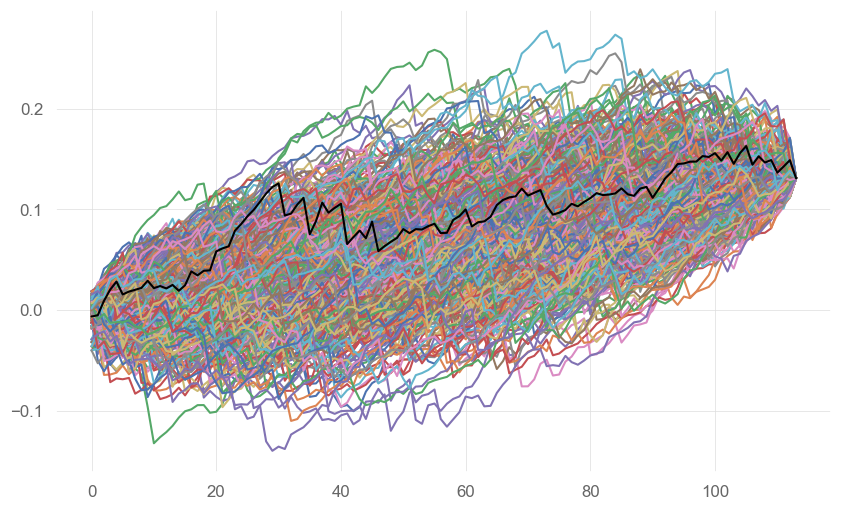

Max Drawdown Stats
-------------------


count    500.000000
mean      -0.074263
std        0.020304
min       -0.141707
25%       -0.085869
50%       -0.070473
75%       -0.060524
max       -0.036939
dtype: float64

In [110]:
trades=pf.trades.records_readable

n_simulations = 500
equity_curves = []

for i in range(n_simulations):
    shuffled_trades = np.random.permutation(trades.Return.to_numpy())
    # equity_curve = pd.Series(shuffled_trades).add(1).cumprod()
    equity_curve = pd.Series(shuffled_trades).cumsum()
    equity_curves.append(equity_curve)

pd.DataFrame(equity_curves).T.plot()
# trades.Return.add(1).cumprod().plot(color='black')
trades.Return.cumsum().plot(color='black')
plt.legend().set_visible(False)
plt.show()

print('Max Drawdown Stats')
print('-------------------')
t = pd.DataFrame(equity_curves).T + 1
t.pct_change().apply(ep.max_drawdown).describe()

##### Noise Test : GBM

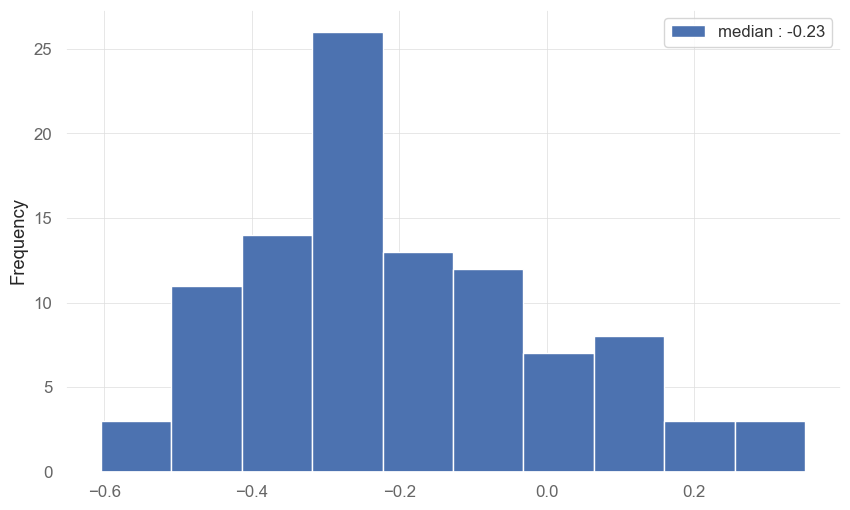

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


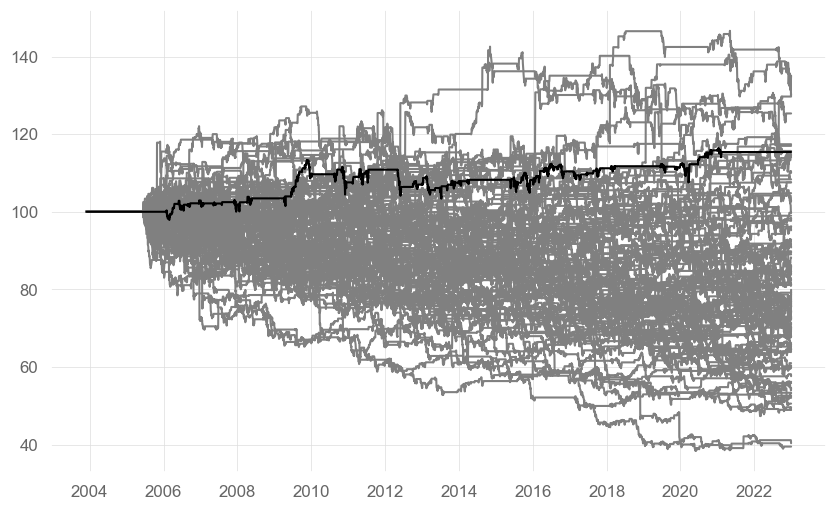

In [116]:
# This robustness test is all about testing the strategy on GBM generated prices

def gmb(returns, num_samples):
    resampled_returns = np.random.choice(returns, size=len(returns), replace=True)
    prices = [closing_prices.iloc[0]]
    for ret in resampled_returns:
        prices.append(prices[-1] * (1 + ret))
    return prices

closing_prices = close[asset]
returns = close[asset].pct_change().dropna().values.tolist()

# Generate 100 random prices, using geometric brownian motion
bootstrap_prices = [gmb(returns, len(closing_prices) - 1) for _ in range(100)]

# Run backtest on GBM prices
_close = close.copy()
close = pd.DataFrame(bootstrap_prices).T
close.index = _close.index

i = ga.explode_individual(individual)
i = i.replace('self.', '')
entry_part, exit_part = i.split('$')

entries = eval(entry_part)
exits = eval(exit_part)

entries.index.name = close.index.name
exits.index.name = close.index.name

if direction == 'L':
    pf = vbt.Portfolio.from_signals(close, entries=entries, exits=exits, fees=0.001)
elif direction == 'S':
    pf = vbt.Portfolio.from_signals(close, short_entries=entries, short_exits=exits, fees=0.001)
elif direction == 'LS':
    pf = vbt.Portfolio.from_signals(close, entries=entries, short_entries=exits, fees=0.001)

# Visualize the ROI Distribution

t = pf.returns().apply(ep.cum_returns_final)
t.plot(kind='hist')
plt.legend([f'mean : {round(t.mean(), 2)}'])
plt.legend([f'median : {round(t.median(), 2)}'])
plt.show()

# Visualize the log equities

plt.plot(pf.value(), color='grey')

close = _close.copy()

entries = eval(entry_part)
exits = eval(exit_part)

entries.index.name = close.index.name
exits.index.name = close.index.name

if direction == 'L':
    pf = vbt.Portfolio.from_signals(close[asset], entries=entries[asset], exits=exits[asset], fees=0.001)
elif direction == 'S':
    pf = vbt.Portfolio.from_signals(close[asset], short_entries=entries[asset], short_exits=exits[asset], fees=0.001)
elif direction == 'LS':
    pf = vbt.Portfolio.from_signals(close[asset], entries=entries[asset], short_entries=exits[asset], fees=0.001)
plt.plot(pf.value(), color='black')
plt.legend().set_visible(False)
plt.show()

##### Variance Test

  0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\billy\AppData\Local\Temp\ipykernel_23380\666020467.py:46: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

100%|██████████| 1000/1000 [00:00<00:00, 1011.96it/s]


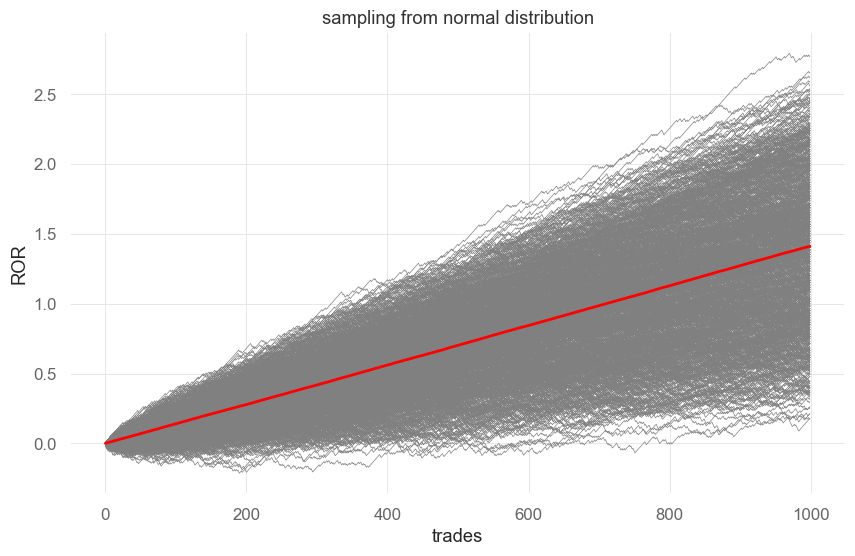

In [117]:
"""
Creates hypothetical equities of varying win rate (5% deviation from the original)

This test is critical, as it essentially summarizes what can happen if you allow 
the law of large numbers to play out, as it enables us to estimate where the equity may be after N trades.
    
More details here:
 - https://www.buildalpha.com/buildalpha-features/
 - https://www.linkedin.com/pulse/variance-testing-easy-way-detect-data-mining-bias-ali-h-askar-cqf/

"""

backtest_results = pf.trades.records_readable.Return
n_simulations = 1000
n_trades = 1000 # specify according to the strategy's trading frequency (the higher the frequency, the higher the n_trades should be)
win_rate_variance = 0.05

# Calculate original win rate
original_win_rate = (backtest_results > 0).mean()

# Calculate win/loss average
pos = backtest_results[backtest_results>0].mean()
neg = backtest_results[backtest_results<0].mean()

# Initialize DataFrame to store results
results = pd.DataFrame(index=range(n_simulations), columns=['profit', 'drawdown'])
equity_curves_df = pd.DataFrame()
dd_df = {}


for i in tqdm(range(n_simulations)):
    # Adjust win rate within variance limits and make sure it's within [0, 1] range
    adjusted_win_rate = np.clip(original_win_rate + (np.random.rand() - 0.5) * 2 * win_rate_variance, 0, 1)

    # Sample trades with adjusted win rate
    _trades = np.random.choice([pos, neg], size=n_trades, p=[adjusted_win_rate, 1-adjusted_win_rate])
    
    # Calculate profit and equity curve
    profit = _trades.sum()
    equity_curve = np.cumsum(_trades)
    
    # Calculate maximum drawdown
    cummax = np.maximum.accumulate(equity_curve)
    drawdown = np.max(cummax - equity_curve)    

    equity_curves_df[i] = pd.Series(equity_curve)
    dd_df[i] = drawdown

# Plotting spaghetti chart
for i in range(n_simulations):
    plt.plot(equity_curves_df[i], color='gray', linewidth=0.5)

# Plotting mean equity curve
plt.plot(equity_curves_df.mean(axis=1), color='red', linewidth=2)
# plt.plot(rets.cumsum().values, color='green')
plt.title('sampling from normal distribution')
plt.xlabel('trades')
plt.ylabel('ROR')
plt.show()

##### White's Reality Check Enhanced (Romano and Wolf)

White's Reality Check is a statistical test used to determine if a trading strategy's performance is statistically significant. It involves bootstrapping the strategy's returns and comparing the observed strategy return to the distribution of bootstrap returns. This enhanced version is based on Romano and Wolf (2024).

More details here : https://drive.google.com/file/d/1khQQ7M5gNEemUMfxGJ2vhHVmsoTB0zYb/view

100%|██████████| 500/500 [03:20<00:00,  2.50it/s]


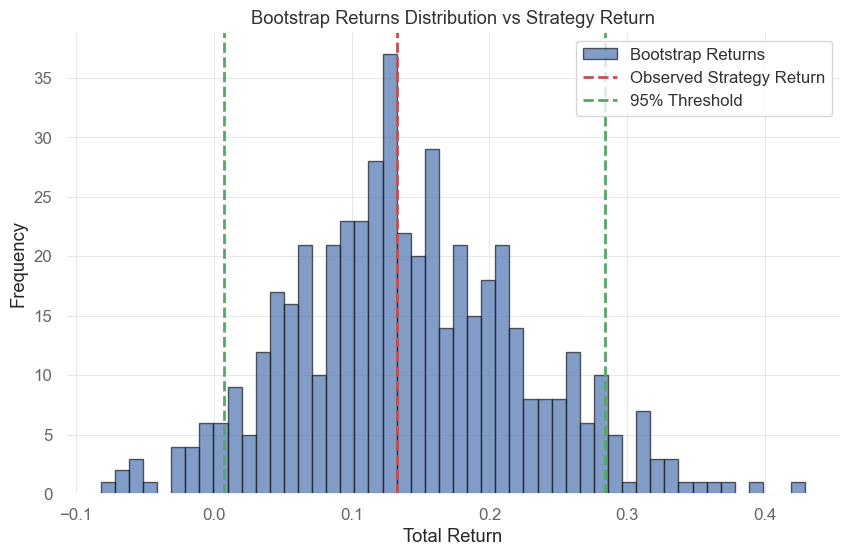

Strategy Total Return: 13.30%


TypeError: unsupported format string passed to Series.__format__

In [170]:
import yfinance as yf
import vectorbt as vbt
import numpy as np
import pandas as pd

# Load OHLCV data
df = pd.read_csv(close_data_path)
df.set_index('time', inplace=True)
df.index = pd.to_datetime(df.index)
df.dropna(inplace=True)
close = df.Close.to_frame(name=asset)
_open = df.Open.to_frame(name=asset)
high = df.High.to_frame(name=asset)
low = df.Low.to_frame(name=asset)
volume = df.Volume.to_frame(name=asset)

# Run backtest on best individual
i = ga.explode_individual(individual)
i = i.replace('self.', '')
entry_part, exit_part = i.split('$')

entries = eval(entry_part)
exits = eval(exit_part)

entries.index.name = close.index.name
exits.index.name = close.index.name

if direction == 'L':
    pf = vbt.Portfolio.from_signals(close[asset], entries=entries[asset], exits=exits[asset], fees=0.001)
elif direction == 'S':
    pf = vbt.Portfolio.from_signals(close[asset], short_entries=entries[asset], short_exits=exits[asset], fees=0.001)
elif direction == 'LS':
    pf = vbt.Portfolio.from_signals(close[asset], entries=entries[asset], short_entries=exits[asset], fees=0.001)

strategy_returns = pf.total_return()
benchmark_returns = (close.iloc[-1] / close.iloc[0]) - 1  # Buy-and-hold

# Reality Check - Bootstrapping
n_bootstrap = 500
bootstrap_returns = []
_close = close.copy()

for _ in tqdm(range(n_bootstrap)):

    # Generate a bootstrap sample
    close = _close.sample(frac=1, replace=True).sort_index()
    close.index = _close.index
    entries = eval(entry_part)
    exits = eval(exit_part)

    entries.index.name = close.index.name
    exits.index.name = close.index.name

    if direction == 'L':
        resampled_portfolio = vbt.Portfolio.from_signals(close[asset], entries=entries[asset], exits=exits[asset], fees=0.001)
    elif direction == 'S':
        resampled_portfolio = vbt.Portfolio.from_signals(close[asset], short_entries=entries[asset], short_exits=exits[asset], fees=0.001)
    elif direction == 'LS':
        resampled_portfolio = vbt.Portfolio.from_signals(close[asset], entries=entries[asset], short_entries=exits[asset], fees=0.001)

    bootstrap_returns.append(resampled_portfolio.total_return())

bootstrap_returns = np.array(bootstrap_returns)
p_value = np.sum(bootstrap_returns >= strategy_returns) / n_bootstrap


# Show Results

plt.hist(bootstrap_returns, bins=50, alpha=0.7, label='Bootstrap Returns', edgecolor='k')
plt.axvline(strategy_returns, color='r', linestyle='--', linewidth=2, label='Observed Strategy Return')
plt.axvline(np.percentile(bootstrap_returns, 95), color='g', linestyle='--', linewidth=2, label='95% Threshold')
plt.axvline(np.percentile(bootstrap_returns, 5), color='g', linestyle='--', linewidth=2)

plt.title("Bootstrap Returns Distribution vs Strategy Return")
plt.xlabel("Total Return")
plt.ylabel("Frequency")
plt.legend()
plt.show()


print(f"Strategy Total Return: {strategy_returns:.2%}")
print(f"Benchmark Buy-and-Hold Return: {benchmark_returns.values[0]:.2%}")
print(f"Reality Check p-value: {p_value:.4f}")

if p_value < 0.05:
    print("The strategy's performance is statistically significant (Reality Check passed).")
else:
    print("The strategy's performance is not statistically significant (Reality Check failed).")



Strategy Total Return: 13.30%
Benchmark Buy-and-Hold Return: -11.92%
Reality Check p-value: 0.5000
The strategy's performance is not statistically significant (Reality Check failed).


-0.11922220436603392